# Predicting Usage of a Video Game Research Server

Frank Wood and his research group from UBC have collected data on the behaviours of various players in a Minecraft server. In particular, they have noted whether or not a player is subscribed to a game-related newsletter. This study aims to determine if played hours and the age of players can accurately predict whether players are subscribed to a game-related newsletter in Wood’s research Minecraft server through a K-Nearest Neighbor classification model.

## Library Loading
The analysis will use the following three libraries:
- *tidyverse* for ...
- *repr* for ...
- *tidymodels* for ...

In [29]:
library(tidyverse)
library(repr)
library(tidymodels)

## Data Loading

In order to build the model, the dataset is first loaded using R's built-in `read_csv` function.

In [30]:
# load data code
players_data <- read_csv("players.csv")
head(players_data)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


## Data Preprocessing

First, the columns are renamed using the `rename` function from the `dplyr` package to ensure consistency across the dataset.

In [31]:
players_data <- rename(players_data,
    is_subscribed = subscribe,
    hashed_email = hashedEmail,
    age = Age)
head(players_data)

experience,is_subscribed,hashed_email,played_hours,name,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


Then the variables of interest are selected from the dataset:
- is_subscribed (target variable)
- played_hours (predictor)
- age (predictor)

In [32]:
players_data <- players_data |>
    select(is_subscribed, played_hours, age)
head(players_data)

is_subscribed,played_hours,age
<lgl>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
TRUE,0.7,21
TRUE,0.1,21
TRUE,0.0,17


Since the `subscribe` column will be used as a categorical variable, it is convereted to a factor type from a logical type using the `as_factor` function.

In [33]:
players_data <- players_data |>
    mutate(is_subscribed = as_factor(is_subscribed))
glimpse(players_data)

Rows: 196
Columns: 3
$ is_subscribed <fct> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, …
$ played_hours  <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, …
$ age           <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 17, 22, 23, 17, 25, 22, 1…


To ensure that the dataset does not contain any missing values, the `drop_na` function is used to remove any observations with empty cells.

In [34]:
players_data <- players_data |> drop_na()

To prepare the data for analysis, the values should also be standardized by scaling with `step_scale` and centering with `step_center`.

In [35]:
std_recipe <- recipe(is_subscribed ~ ., data = players_data) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    prep()
std_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Training information 

Training data contained 194 data points and no incomplete rows.



── Operations 

• Scaling for: played_hours and age | Trained

• Centering for: played_hours and age | Trained



In [36]:
players_data <- bake(std_recipe, players_data)
head(players_data)

played_hours,age,is_subscribed
<dbl>,<dbl>,<fct>
0.85603962,-1.86578776,TRUE
-0.07385234,-0.57017138,TRUE
-0.20719534,-0.57017138,FALSE
-0.18263216,0.07763681,TRUE
-0.20368631,0.07763681,TRUE
-0.20719534,-0.57017138,TRUE


To get a hold of what the dataset looks like, `group_by` and `summarize` is used to figure out the number and percentage of observations for both subscribed and unsubscribed players.

In [37]:
num_obs <- nrow(players_data)
players_data |>
    group_by(is_subscribed) |>
    summarize(
        count = n(),
        percentage = n() / num_obs * 100
    )

is_subscribed,count,percentage
<fct>,<int>,<dbl>
FALSE,52,26.80412
TRUE,142,73.19588


The results show that there is class imabalnce in the dataset as subscribed players are found much more often than unsubscribed players. To get around this issue, the rarer class, unsubscribed players, will be oversampled by replicating the observations.

In [38]:
library(themis)
ups_recipe <- recipe (is_subscribed ~ ., data = players_data) |>
    step_upsample(is_subscribed, over_ratio = 1, skip = FALSE) |>
    prep()
ups_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Training information 

Training data contained 194 data points and no incomplete rows.



── Operations 

• Up-sampling based on: is_subscribed | Trained



In [39]:
players_data <- bake(ups_recipe, players_data)
num_obs <- nrow(players_data)
players_data |>
    group_by(is_subscribed) |>
    summarize(
        count = n(),
        percentage = n() / num_obs * 100
    )

is_subscribed,count,percentage
<fct>,<int>,<dbl>
FALSE,142,50
TRUE,142,50


## Exploratory Data Visualization

A colorblind-friendly scatter plot is created with `ggplot` to help visualize the two predictor variables: played_hours and age.

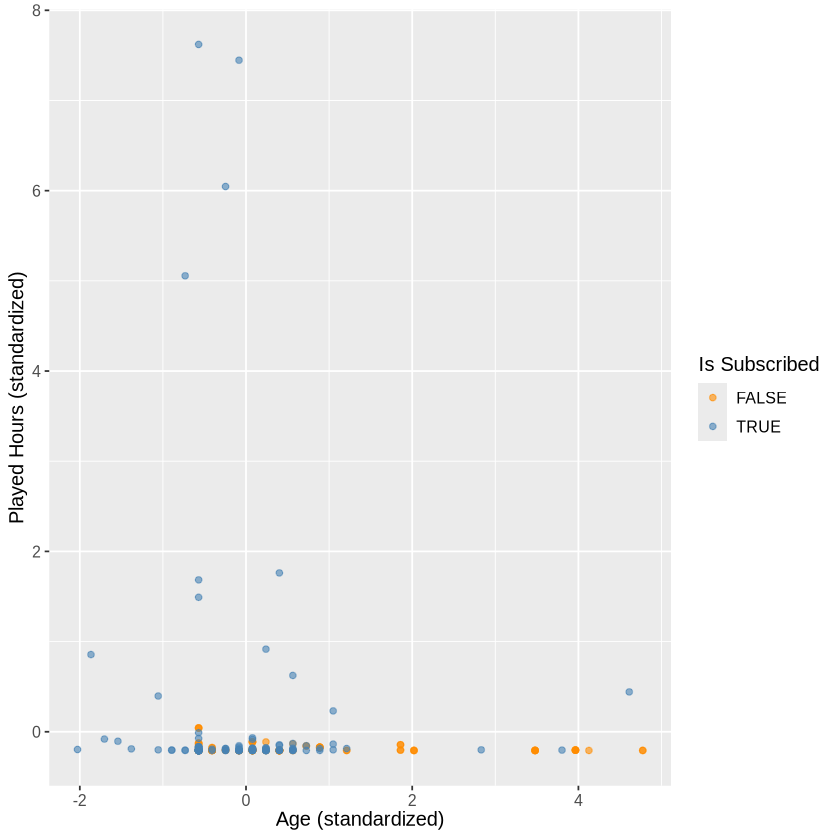

In [41]:
hours_age_plot <- ggplot(players_data, aes(x = age, y = played_hours, color = is_subscribed)) +
    geom_point(alpha = 0.6) +
    labs(x = "Age (standardized)",
         y = "Played Hours (standardized)",
         color = "Is Subscribed") +
    scale_color_manual(values = c("darkorange", "steelblue")) +
    theme(text = element_text(size = 12))
hours_age_plot